In [1]:
from glob import glob
from os.path import isfile
from os.path import isdir
import os
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import datetime
import matplotlib.pylab as pylab

In [2]:
def compute_tsnr(fnames,out_dir,hemi):
    if not isdir(out_dir): os.mkdir(out_dir)
    for dd in fnames:
        print(dd)
        subj = re.search('SNP\d+_SYM_Y\d',dd)[0]
        file_out = f'{out_dir}/TSNR.{subj}.{hemi}.1D'
        if not isfile(file_out):
            # Compute standard deviation across the residual dataset
            !3dTstat -stdev -overwrite -prefix rm.noise.niml.dset {dd}
            # Compute the TSNR, assuming mean of 100 (since data was previously scaled)
            !3dcalc -overwrite -verbose -a rm.noise.niml.dset \
                    -expr "100/a" -prefix {file_out}
    !rm -f rm*

In [3]:
def compute_mean(dnames,out_dir,hemi):
    if not isdir(out_dir): os.mkdir(out_dir)
    for dd in dnames:
        print(dd)
        subj = re.search('SNP\d+_SYM_Y\d',dd)[0]
        file_out = f'{out_dir}/MEAN.{subj}.{hemi}.1D'
        if not isfile(file_out):
            # Create a temporary dataset including data from all runs
            !3dTcat -overwrite -prefix rm.all_runs.niml.dset {dd}pb03.*_SYM_Y*.{hemi}.*.blur.niml.dset
#             # NOT DOING THIS SINCE IT AUTOMATICALLY REMOVES MEAN
#             # Censor the data for motion volumes
#             !3dTproject -overwrite -polort 0 -censor {dd}censor_{subj}_combined_2.1D \
#                 -prefix rm.censored.niml.dset -input rm.all_runs.niml.dset
#             # Create a mean dataset
#             !3dTstat -overwrite -mean -prefix {file_out} rm.censored.niml.dset
            !3dTstat -overwrite -mean -prefix {file_out} rm.all_runs.niml.dset
    !rm -f rm*

In [4]:
def load_1Ds_to_dataframe(fnames):
    # Load data into dataframe
    df = pd.DataFrame()
    for idx, ii in enumerate(fnames):
        d = pd.read_csv(ii,header=None,squeeze=True,comment='#')
        #df = df.assign(idx=d.values)
        df = pd.concat([df, d.rename(f'sess{idx}')], axis=1)
    return df

In [5]:
def generate_figs_and_postproc_files(df):
    params = {'legend.fontsize': 'xx-large',
              'figure.figsize': (15, 5),
             'axes.labelsize': 'xx-large',
             'axes.titlesize':'xx-large',
             'xtick.labelsize':'xx-large',
             'ytick.labelsize':'xx-large'}
    pylab.rcParams.update(params)
    
    f, ax = plt.subplots(1, 1, figsize = (18, 9))

    for ii in range(len(df.columns)):
        # Draw the density plots
        sns.kdeplot(df.iloc[:,ii],ax=ax, linewidth=0.5, color='red')

    # Plot formatting
    plt.title('Density Plots for each session')
    plt.ylabel('Density')
    #plt.xlim([0,275])
    plt.grid()
    
    # Compute MAD and plot for each subject
    MAD = stats.median_abs_deviation(df,scale=1)
    cutoff_2MAD = df.median() - (2 * MAD)
    for ii in range(len(df.columns)):
        plt.axvline(cutoff_2MAD[ii], linewidth=0.5, color='blue')
    
    unique_tag = datetime.datetime.now().strftime('%Y%m%d%H%M%S%f')
    plt.savefig(f'Distribution_plot_{unique_tag}.png')
    
    return cutoff_2MAD
    

In [6]:
def threshold_data_by_MAD(df,cutoff):
    df_thresh = pd.DataFrame()
    for ind, column in enumerate(df.columns):
        d = df[column]
        c = cutoff[ind]
        d[d <= c] = 0
        d[d > c] = 1
        df_thresh = pd.concat([df_thresh, d],axis=1) 
        
    df_group_mean = df.mean(axis=1)  
        
    return df_thresh, df_group_mean

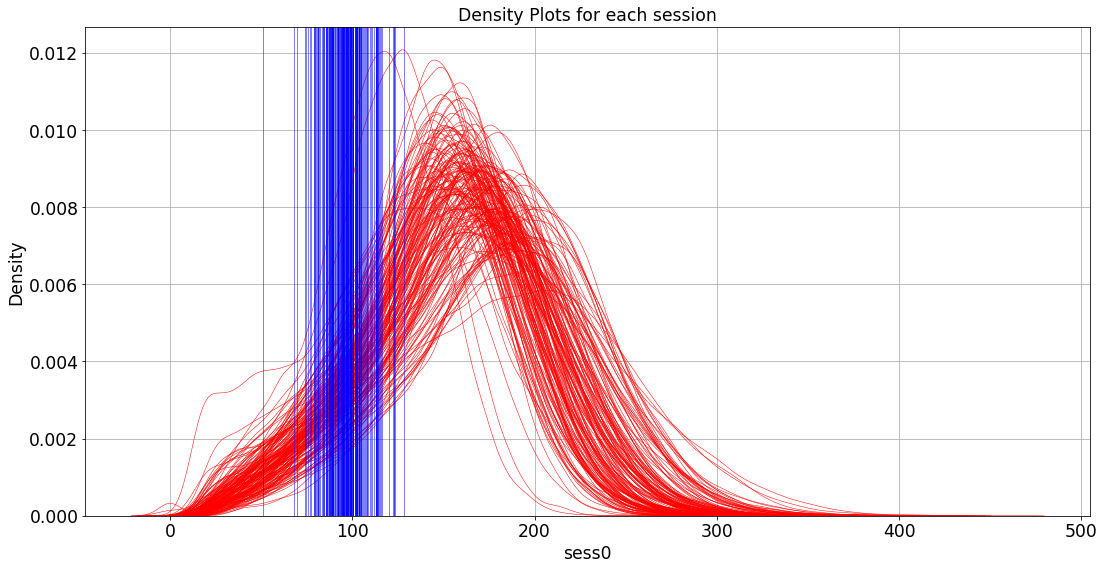

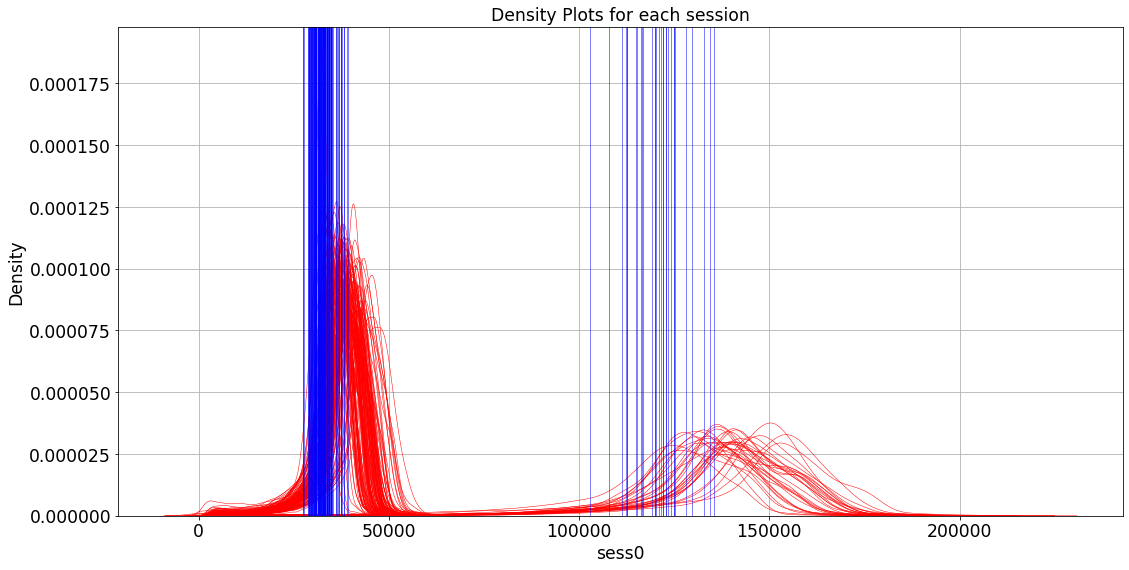

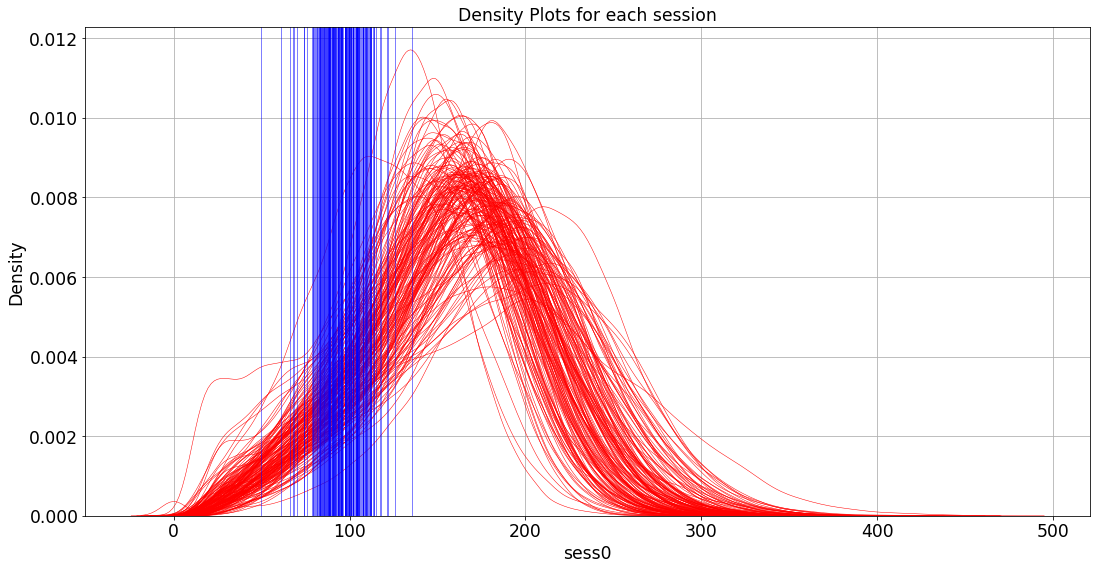

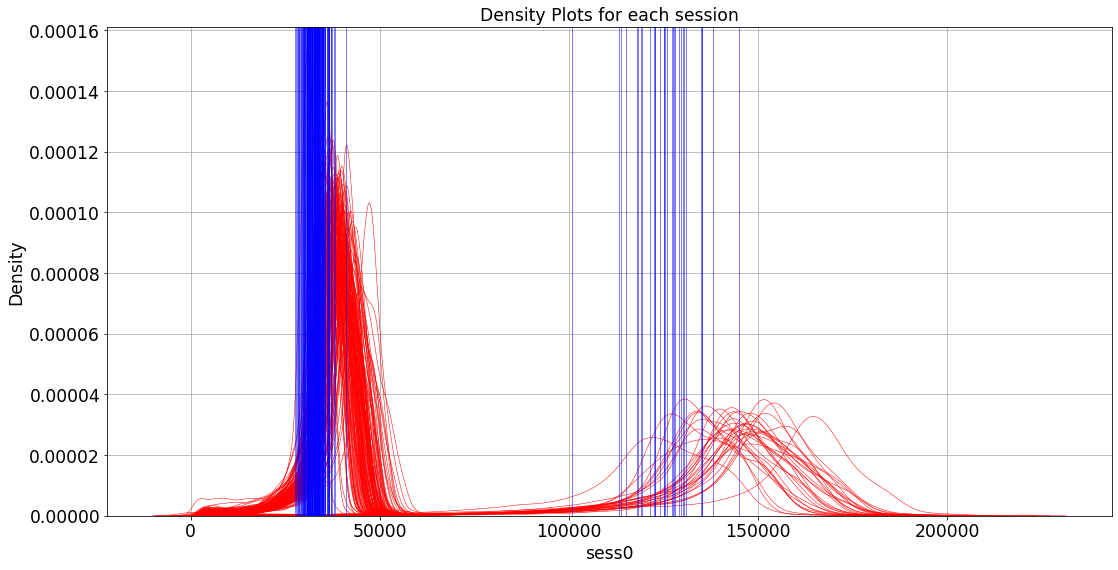

In [23]:
# Perform the pipeline for each hemisphere separately
hemis = ['lh','rh']
for hemi in hemis:
    # Set output directory
    out_dir = ('/Volumes/NBL_Projects/NSF_SNP/matfiles/preprocessing_pipeline_surface_analyses/'
              f'Analysis_in_Python/{hemi}_smooth')
    
#     # Create TSNR and Mean signal datasets for each MRI session
#     # TSNR
#     fnames = glob('/Volumes/NBL_Projects/NSF_SNP/Processed_Data/SNP*/'
#                   'Y*/SYM/proc/SNP*_SYM_Y*.surface.univariate/'
#                   f'errts.SNP*_SYM_Y*.{hemi}_REML.niml.dset')
#     compute_tsnr(sorted(fnames),out_dir,hemi)
#     # MEAN
#     dnames = glob('/Volumes/NBL_Projects/NSF_SNP/Processed_Data/SNP*/'
#                   'Y*/SYM/proc/SNP*_SYM_Y*.surface.beta_series/')
#     compute_mean(sorted(dnames),out_dir,hemi)
    
    write_params = {'sep':'\t', 'header':False, 'index':False}
    # Analyze the TSNR data
    tsnr_files = glob(out_dir + f'/TSNR*.{hemi}.1D')
    df_tsnr = load_1Ds_to_dataframe(tsnr_files)
    cutoff_tsnr = generate_figs_and_postproc_files(df_tsnr)
    df_tsnr_thresh, df_tsnr_group = threshold_data_by_MAD(df_tsnr,cutoff_tsnr)
    df_tsnr_thresh.to_csv(f'TSNR_2MAD_Threshold_AllSubs_{hemi}_smooth.1D',**write_params)
    df_tsnr_group.to_csv(f'TSNR_2MAD_Threshold_Mean_{hemi}_smooth.1D', **write_params)

    # Analyze the Mean signal data
    mean_files = glob(out_dir + f'/MEAN*.{hemi}.1D')
    df_mean = load_1Ds_to_dataframe(mean_files)≠≠
    cutoff = generate_figs_and_postproc_files(df_mean)
    df_mean_thresh, df_mean_group = threshold_data_by_MAD(df_mean,cutoff)
    df_mean_thresh.to_csv(f'MEAN_2MAD_Threshold_AllSubs_{hemi}_smooth.1D', **write_params)
    df_mean_group.to_csv(f'MEAN_2MAD_Threshold_Mean_{hemi}_smooth.1D', **write_params)
    
    # Create final mask datasets (based on <=66.66% sessions with poor signal)
    df_tsnr_group_66 = df_tsnr_group <= .6666
    df_tsnr_group_66.astype(int).to_csv(f'TSNR_2MAD_Mask_66perc_{hemi}_smooth.1D', **write_params)
    df_mean_group_66 = df_mean_group <= .6666
    df_mean_group_66.astype(int).to_csv(f'MEAN_2MAD_Mask_66perc_{hemi}_smooth.1D', **write_params)
    df_group_mask = (df_tsnr_group_66) & (df_mean_group_66)
    df_group_mask.astype(int).to_csv(f'UNION_2MAD_Mask_66perc_mask_{hemi}_smooth.1D', **write_params)
